수준이상 → Level deviation
(기준 레벨 대비 높이 차이, 흔히 track level irregularity로도 표현)

고저 → Cross level
(레일을 따라 진행 방향의 높낮이 변화, vertical profile irregularity)

평면성 → Planarity 또는 Track plane accuracy
(궤도가 하나의 평면상에 놓여 있는 정도)

평탄성 → Longitudinal level irregularity
(노면의 전체적인 매끄러움 정도, ride comfort 관련)

안내레일 내측거리 → Check gauge 또는 Guard rail clearance
(안내레일/가드레일과 주 레일 사이의 내측 거리)

연결부 단차 → Joint offset 또는 Joint step
(레일 이음매 부분에서 발생하는 단차)

직진도 → Alignment (특히 Straightness of alignment)
(진행 방향에서 궤도가 직선으로 얼마나 잘 유지되는지)

In [20]:
# 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# font 맑은고딕 
# plt.rc('font', family='Malgun Gothic')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# load 2509231006_data(0+000.00m)
# df = pd.read_csv("2509231006_data(0+000.00m).csv")
# df = pd.read_csv("2509181942.csv")
# filename = "2509181942.csv"
filename = "2509302059.csv"
# filename = "2509191359.csv"
# filename = "2509231006.csv"
df_raw = pd.read_csv(filename)
# Index,Timestamp,UnixTimestamp를 제외한 모든 column의 type 변경
df_raw = df_raw.astype({col: float for col in df_raw.columns if col not in ['Index', 'Timestamp', 'UnixTimestamp']})


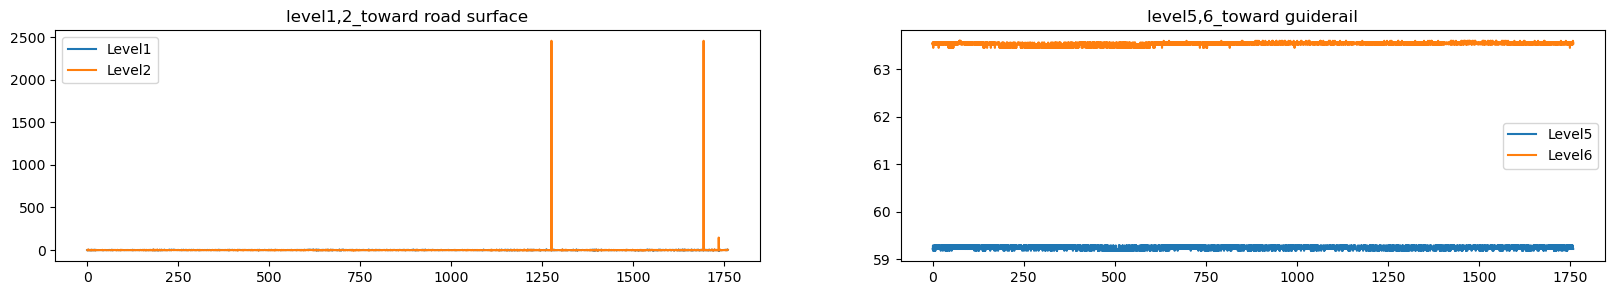

In [21]:
# plot the data, 'Travelled' as x, 'Level1' as y, 'Level2' as y2 (top subplot with title level1,2_toward road surface)

plt.figure(figsize=(20,3))
plt.subplot(1,2,1)
plt.plot(df_raw['Travelled'], df_raw['Level1'], label='Level1')
plt.plot(df_raw['Travelled'], df_raw['Level2'], label='Level2')
plt.title("level1,2_toward road surface")
plt.legend()
plt.subplot(1,2,2)
plt.plot(df_raw['Travelled'], df_raw['Level5'], label='Level5')
plt.plot(df_raw['Travelled'], df_raw['Level6'], label='Level6')
plt.title("level5,6_toward guiderail")
plt.legend()
plt.show()


In [22]:
# preprocessing

# 0. dropna 
df_raw.dropna(inplace=True)
# ['Level1','Level2','Level3','Level4','Level5','Level6'에서, 200 이상인 값이 있는 행을 제거

mask = (df_raw[['Level1','Level2','Level3','Level4','Level5','Level6']] < 200).all(axis=1)  # 주석과 일치: 200 이상 제거
df_raw = df_raw[mask]

df_before = df_raw.copy(deep=True)

# --- 3) 구간 집계 (평균). pd.cut으로 구간 만들고, 그룹 평균 후 상한값을 Travelled로 복원
AGG_PERIOD = 1  # [m] 구간폭
df_agg = df_before.copy(deep=True)

# bins 상한 포함을 위해 max에 여유를 더해줌
tmax = float(df_agg['Travelled'].max())
bins = range(0, int(tmax) + AGG_PERIOD*2, AGG_PERIOD)  # 여유 1칸

# 구간 레이블 생성 (Interval)
df_agg['bin'] = pd.cut(df_agg['Travelled'], bins=bins)

# 평균 계산: bin을 인덱스로 갖는 집계 프레임 생성
num_cols = [c for c in ['Level1','Level2','Level3','Level4','Level5','Level6','Encoder3','Ang1','Ang2','Ang3'] if c in df_agg.columns]
df_agg = (
    df_agg.groupby('bin')[num_cols].mean()
)

# 인덱스(IntervalIndex)에서 상한값(right)을 꺼내 Travelled로 사용
# 방법 A) 인덱스 그대로 활용
df_agg.reset_index(inplace=True)
df_agg['Travelled'] = df_agg['bin'].apply(lambda x: x.right)

# (선택) 마지막 구간 제거하고 싶다면: 상한이 전체 최대값 이상인 구간 drop
# df_agg = df_agg[df_agg['Travelled'] < tmax]

# 열 조작
cols = ['Travelled'] + [c for c in df_agg.columns.tolist() if c != 'Travelled'] # 열 순서 변경
df_agg = df_agg[cols]

df_agg.to_csv(filename.replace('.csv', '_agg.csv'), index=False)

df = df_agg.drop(columns=['bin'])

# df_agg.tail()

In [23]:


# aggregation 전후 데이터 확인
print(f"aggregation 전 데이터 수: {len(df_before)}")
print(f"aggregation 후 데이터 수: {len(df)}")

# 2. outlier_removal(IQR then z-score)
# 각 열별로 IQR 기준(outlier) 탐지 후, 값을 "앞/뒤 가장 가까운 비이상치의 평균"으로 대체

iqr_k = 1.5       # IQR 배수 (일반적으로 1.5)
z_thresh = 3.0    # z-score 임계치 (일반적으로 3.0)

def iqr_mask(s: pd.Series, k: float = 1.5) -> pd.Series:
    """IQR 기준 이상치 마스크(True = 이상치). NaN은 False 처리."""
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k * iqr, q3 + k * iqr
    m = (s < lower) | (s > upper)
    return m.fillna(False)

def zscore_mask(s: pd.Series, thresh: float = 3.0) -> pd.Series:
    """z-score 기준 이상치 마스크. 표준편차 0이면 이상치 없음으로 처리."""
    mu = s.mean()
    sigma = s.std()
    if sigma == 0 or np.isnan(sigma):
        return pd.Series(False, index=s.index)
    z = (s - mu) / sigma
    m = z.abs() > thresh
    return m.fillna(False)

def replace_with_neighbor_mean(s: pd.Series, mask: pd.Series) -> pd.Series:
    """
    마스크가 True인 위치를 '가장 가까운 앞/뒤 비이상치 평균'으로 대체.
    - 양쪽 모두 존재: 평균
    - 한쪽만 존재: 그 한쪽 값
    - 둘 다 없음(연속 이상치가 끝/처음에서 시작 등): 열의 중앙값으로 대체
    """
    out = s.copy()
    # 비이상치만 남기고 이상치는 NaN으로 비워 이웃값 채우기 준비
    tmp = s.copy()
    tmp[mask] = np.nan

    prev = tmp.ffill()   # 바로 앞 비이상치
    nxt  = tmp.bfill()   # 바로 뒤 비이상치

    # 양쪽 모두 있으면 평균, 한쪽만 있으면 그 값 사용
    repl = (prev + nxt) / 2.0
    repl = repl.where(prev.notna() & nxt.notna(), prev.fillna(nxt))

    out[mask] = repl[mask]

    # 아직 못 채운 값(양쪽 다 없던 자리)은 중앙값으로 대체
    if out[mask].isna().any():
        out.loc[mask & out.isna()] = s.median()

    return out

df_clean = df.copy()

# iqr, z-score 기준 이상치 제거
for col in ['Level1','Level2','Level3','Level4','Level5','Level6','Encoder3','Ang1','Ang2','Ang3']:
    s = pd.to_numeric(df_clean[col], errors='coerce')  # 숫자형 보장

     # IQR 기준
    m_iqr = iqr_mask(s, k=iqr_k)
    cnt_iqr = m_iqr.sum()
    s = replace_with_neighbor_mean(s, m_iqr)

    # z-score 기준
    m_z = zscore_mask(s, thresh=z_thresh)
    cnt_z = m_z.sum()
    s = replace_with_neighbor_mean(s, m_z)

    df_clean[col] = s

    print(f"[{col}] IQR 대체: {cnt_iqr}개, z-score 대체: {cnt_z}개")



aggregation 전 데이터 수: 13648
aggregation 후 데이터 수: 1760
[Level1] IQR 대체: 81개, z-score 대체: 0개
[Level2] IQR 대체: 31개, z-score 대체: 0개
[Level3] IQR 대체: 147개, z-score 대체: 0개
[Level4] IQR 대체: 172개, z-score 대체: 0개
[Level5] IQR 대체: 54개, z-score 대체: 0개
[Level6] IQR 대체: 2개, z-score 대체: 0개
[Encoder3] IQR 대체: 176개, z-score 대체: 0개
[Ang1] IQR 대체: 270개, z-score 대체: 0개
[Ang2] IQR 대체: 0개, z-score 대체: 0개
[Ang3] IQR 대체: 0개, z-score 대체: 0개


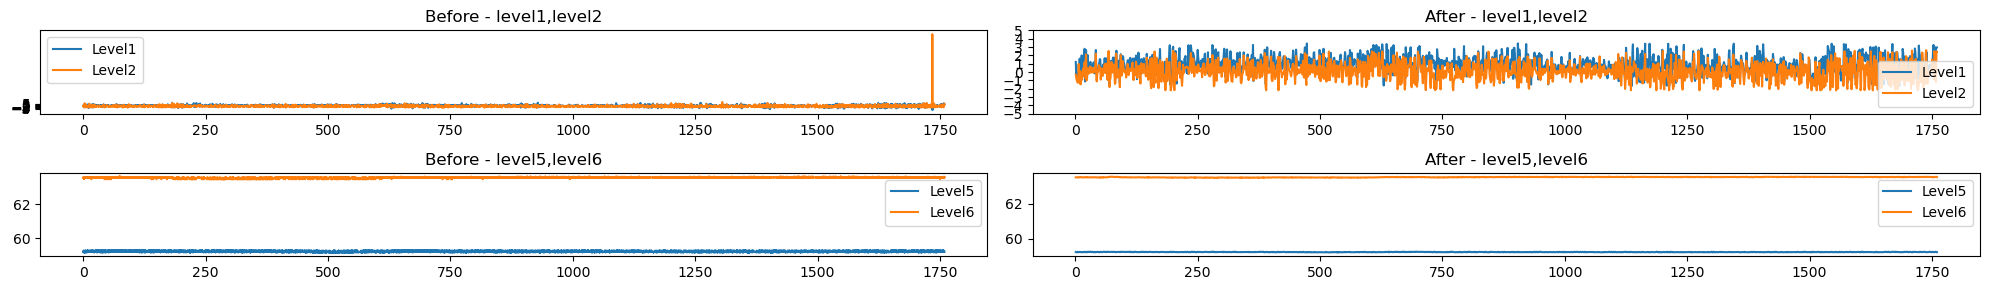

In [32]:
# ---- 플롯: 좌(보정 전) / 우(보정 후) ----
fig, axes = plt.subplots(2, 2, figsize=(20, 3))
pairs = [(('Level1','Level2'), 0), (('Level5','Level6'), 1)]

for (cols, row) in pairs:
    for j, (df_, title) in enumerate([(df_before, 'Before'), (df_clean, 'After')]):
        ax = axes[row, j]
        for col in cols:
            ax.plot(df_['Travelled'], df_[col], label=col)
        if row == 0:  # 위쪽만 ytick 설정
            ax.set_yticks(np.arange(-5, 6, 1))
        ax.set_title(f"{title} - {','.join(cols).lower()}")
        ax.legend()

plt.tight_layout()
plt.show()

In [27]:
df_clean.head()

df_clean.to_csv(filename.replace('.csv', '_clean.csv'), index=False)

## Level Deviation

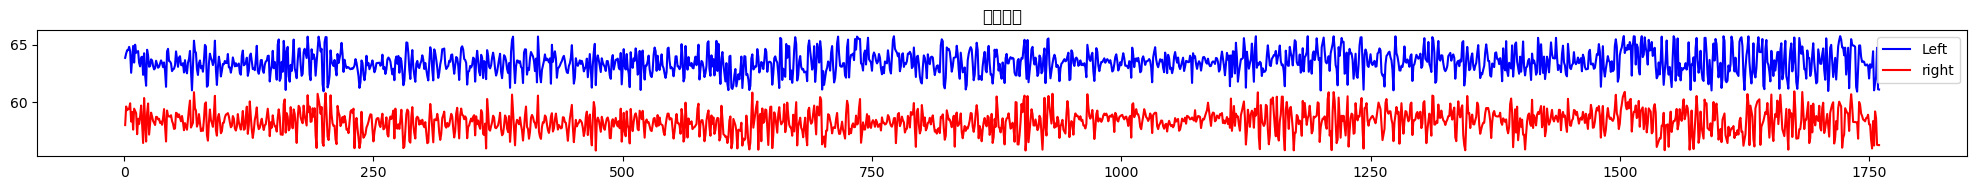

In [33]:
# calc level_deviation
df_res= df_clean.copy(deep=True).loc[:,['Travelled', 'Level1','Level2','Level5','Level6']]


df_res['Left'] = df_res['Level6']- df_res['Level2']
df_res['Right'] = df_res['Level5']- df_res['Level1']

plt.figure(figsize=(20,2))
plt.plot(df_res['Travelled'], df_res['Left'], label = 'Left', color='blue')
plt.plot(df_res['Travelled'], df_res['Right'], label='right', color='red')
plt.title('수준이상')
plt.legend()


plt.tight_layout()
plt.show()

## Cross Level

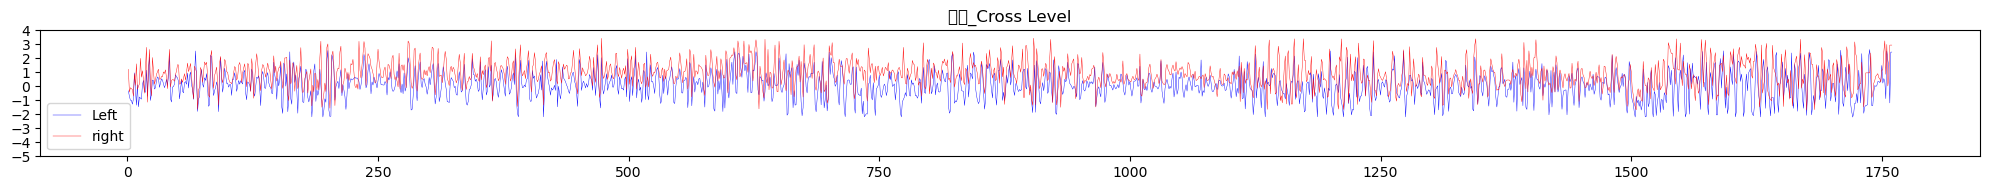

In [29]:
# calc level_deviation
df_res= df_clean.copy(deep=True).loc[:,['Travelled', 'Level1','Level2','Level5','Level6']]


df_res['cross_level_Left'] = df_res['Level2']
df_res['cross_level_Right'] = df_res['Level1']

plt.figure(figsize=(20,2))
plt.plot(df_res['Travelled'], df_res['cross_level_Left'], label = 'Left', color='blue', linewidth=0.3)
plt.plot(df_res['Travelled'], df_res['cross_level_Right'], label='right', color='red', linewidth=0.3)
plt.title('고저_Cross Level')
plt.yticks(np.arange(-5,5,1))
plt.legend()


plt.tight_layout()
plt.show()

# Lon. Level irregularity

In [30]:
# df_before 에서 구간별 표준편차 구하기 

# raw 데이터에서 이상치만 제거, 이후 구간별 표준편차 구하기

AGG_PERIOD = 3  # [m] 구간폭
df_lonlevel = df_before.copy(deep=True)
df_lonlevel = df_lonlevel.loc[:,['Travelled', 'Level1','Level2']]
# iqr, z-score 기준 이상치 제거
for col in ['Level1','Level2']:
    s = pd.to_numeric(df_lonlevel[col], errors='coerce')  # 숫자형 보장

     # IQR 기준
    m_iqr = iqr_mask(s, k=iqr_k)
    cnt_iqr = m_iqr.sum()
    s = replace_with_neighbor_mean(s, m_iqr)

    # z-score 기준
    m_z = zscore_mask(s, thresh=z_thresh)
    cnt_z = m_z.sum()
    s = replace_with_neighbor_mean(s, m_z)

    df_lonlevel[col] = s

    print(f"[{col}] IQR 대체: {cnt_iqr}개, z-score 대체: {cnt_z}개")

# bins 상한 포함을 위해 max에 여유를 더해줌
tmax = float(df_lonlevel['Travelled'].max())
bins = range(0, int(tmax) + AGG_PERIOD*2, AGG_PERIOD)  # 여유 1칸

# 구간 레이블 생성 (Interval)
df_lonlevel['bin'] = pd.cut(df_lonlevel['Travelled'], bins=bins)


# 표준편차 계산: bin을 인덱스로 갖는 집계 프레임 생성
num_cols = [c for c in ['Level1','Level2','Level3','Level4','Level5','Level6','Encoder3','Ang1','Ang2','Ang3'] if c in df_lonlevel.columns]
df_lonlevel = (
    df_lonlevel.groupby('bin')[num_cols].std()
)

# 인덱스(IntervalIndex)에서 상한값(right)을 꺼내 Travelled로 사용
# 방법 A) 인덱스 그대로 활용
df_lonlevel.reset_index(inplace=True)
df_lonlevel['Travelled'] = df_lonlevel['bin'].apply(lambda x: x.right)

# (선택) 마지막 구간 제거하고 싶다면: 상한이 전체 최대값 이상인 구간 drop
# df_agg = df_agg[df_agg['Travelled'] < tmax]

# 열 조작
cols = ['Travelled'] + [c for c in df_lonlevel.columns.tolist() if c != 'Travelled'] # 열 순서 변경
df_lonlevel = df_lonlevel[cols]

df_lonlevel = df_lonlevel[['Travelled','Level1', 'Level2']]


df_lonlevel.to_csv(filename.replace('.csv', '_lonlevel.csv'), index=False)
df_lonlevel.head()



[Level1] IQR 대체: 786개, z-score 대체: 0개
[Level2] IQR 대체: 346개, z-score 대체: 0개


,Travelled,Level1,Level2
0,3,1.297366,1.692702
1,6,1.413442,1.599822
2,9,1.490158,1.073754
3,12,1.446972,1.244180
4,15,1.185488,1.435203


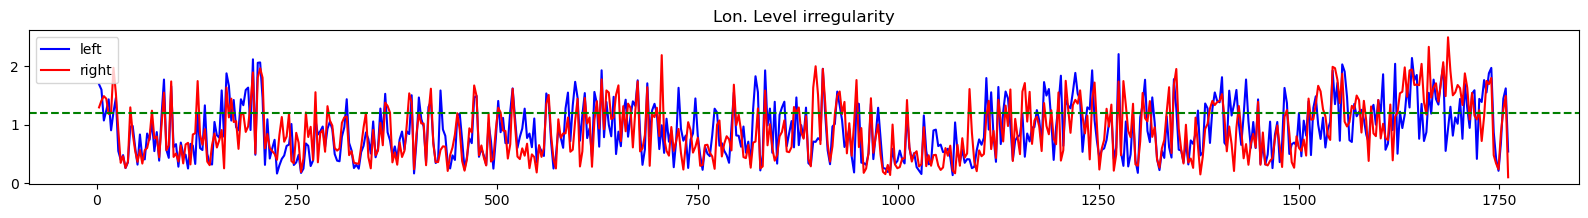

In [31]:
plt.figure(figsize=(20,2))
plt.plot(df_lonlevel['Travelled'], df_lonlevel['Level2'], label='left', color='blue')
plt.plot(df_lonlevel['Travelled'], df_lonlevel['Level1'], label='right', color='red')
# x=1.2 에 수직선 그리기
plt.axhline(y=1.2, color='green', linestyle='--')

plt.title('Lon. Level irregularity')
plt.legend()
plt.show()

# EOF

In [157]:
# Travelled 기준 3m 씩 끊어서 level1, level2 각각의 ema 계산
# Travelled 기준 3m 단위 구간 생성
TERM = 1

df_pl = df.loc[:, ['Travelled', 'Level1', 'Level2']]


df_pl['bin'] = pd.cut(df_pl['Travelled'], bins=range(0, int(df_pl['Travelled'].max()) + TERM, TERM))

# # 각 구간별 EMA 계산
# # span=10 은 예시 → 원하는 EMA 스무딩 정도에 맞게 조정
# 각 bin별 EMA의 마지막 값 추출
df_pl = df_pl.sort_values('Travelled')

def last_ema_row(g):
    # NaN만 있어도 값 나오게 min_periods=1
    ema = g[['Level1','Level2']].ewm(span=5, min_periods=1).mean()
    # g가 비어있으면 방어
    return ema.iloc[-1] if len(ema) else pd.Series({'Level1': np.nan, 'Level2': np.nan})

# agged_pl = (
#     df_pl
#     .groupby('bin', observed=True)[['Level1','Level2']]  # observed=True로 빈 카테고리 bin 제외
#     .apply(last_ema_row)
#     .reset_index()
# )
agged_pl = (
    df_pl.groupby('bin')[['Level1', 'Level2']]
    .mean()
)


# bin을 대표 Travelled 값(구간 상한)으로 변환
agged_pl = agged_pl.reset_index()
agged_pl['Travelled'] = agged_pl['bin'].apply(lambda x: x.right)  # 구간 상한값 사용
agged_pl = agged_pl[['Travelled', 'Level1', 'Level2']]

# IQR 기준 범위 벗어나는 데이터 주위 평균값으로 대체




agged_pl.head()

# Travelled를 3m 단위로 binning
# df_pl['bin'] = (df_pl['Travelled'] / 3).round() * 3

# # 각 bin에서 Travelled과 bin 차이가 가장 작은 행만 남김
# agged_pl = (
#     df_pl.loc[df_pl.groupby('bin')['Travelled']
#               .apply(lambda x: (x - x.name).abs().idxmin())]
#     .reset_index(drop=True)
# )
# agged_pl['Travelled'] = agged_pl['bin']  # 구간 상한값 사용

# print(agged_pl)
agged_pl

KeyError: "['Travelled'] not in index"

In [ ]:


# index별로 dataframe 순회
# 문제: DataFrame 생성 및 컬럼 할당 방식이 잘못됨(iloc의 두 번째 인자, DataFrame 생성 방식 등)
# 해결: 각 row를 dict로 만들어 리스트에 저장 후, DataFrame으로 변환

pts_rows = []
for i in range(1, len(agged_pl)):
    row = {
        'Travelled': agged_pl.iloc[i]['Travelled'],
        'flh': agged_pl.iloc[i]['Level2'],
        'frh': agged_pl.iloc[i]['Level1'],
        'rlh': agged_pl.iloc[i-1]['Level2'],
        'rrh': agged_pl.iloc[i-1]['Level1'],
    }
    pts_rows.append(row)

pts_pl = pd.DataFrame(pts_rows, columns=['Travelled', 'flh', 'frh', 'rlh', 'rrh'])


In [ ]:
import numpy as np


def plane_from_3pts_matrix(p1, p2, p3):
    """
    세 점으로 평면식 ax+by+cz+d=0을 구한다.
    외적 기반 (더 안정적이고 효율적)
    """
    p1, p2, p3 = map(lambda p: np.asarray(p, np.float64), (p1, p2, p3))
    
    # 세 점이 유효한지 확인
    if p1.shape != (3,) or p2.shape != (3,) or p3.shape != (3,):
        raise ValueError("각 점은 3D 좌표여야 합니다")
    
    # 두 벡터 생성
    v1 = p2 - p1
    v2 = p3 - p1
    
    # 외적으로 법선 벡터 구하기
    normal = np.cross(v1, v2)
    
    # 세 점이 일직선상에 있는지 확인
    if np.allclose(normal, 0):
        raise ValueError("세 점이 일직선상에 있거나 동일합니다")
    
    # 법선 벡터 정규화
    normal = normal / np.linalg.norm(normal)
    
    # d = -(ax0 + by0 + cz0)
    d = -np.dot(normal, p1)
    
    return np.array([normal[0], normal[1], normal[2], d])


In [ ]:
def z_axis_distance(plane, point):
    """
    평면과 한 점 간의 z축 방향 거리 계산.
    
    Parameters
    ----------
    plane : (a,b,c,d)
        평면식 ax+by+cz+d=0 계수
    point : (x,y,z)
        대상 점 좌표
    
    Returns
    -------
    float
        z축 방향 거리 (점의 z - 평면 z)
        >0 이면 점이 평면보다 위쪽(z+)에 있음
    """
    a, b, c, d = plane
    x, y, z = point

    if abs(c) < 1e-12:
        raise ValueError("이 평면은 z에 대해 해를 풀 수 없습니다 (c=0).")

    z_plane = -(a*x + b*y + d) / c
    return z - z_plane

In [ ]:
# test

p1 = [1,1,1]
p2 = [-1,-1,-1]
p3 = [-0.5,0.5,0]

plane = plane_from_3pts_matrix(p1,p2,p3)
print(plane)


z_dist = z_axis_distance(plane,(0.5,0.5,0))
z_dist

[ 0.40824829  0.40824829 -0.81649658 -0.        ]


np.float64(-0.5)

In [ ]:
dst = pd.DataFrame()


for i in range(len(pts_pl)):
    p1 = [-750, 1500, pts_pl.loc[i,'flh']]
    p2 = [750, 1500, pts_pl.loc[i,'frh']]
    p3 = [-750, -1500, pts_pl.loc[i,'rlh']]
    p4 = [750, -1500, pts_pl.loc[i,'rrh']]

    flh_plane = plane_from_3pts_matrix(p2, p3, p4)
    frh_plane = plane_from_3pts_matrix(p1, p3, p4)
    rlh_plane = plane_from_3pts_matrix(p1, p2, p4)
    rrh_plane = plane_from_3pts_matrix(p1, p2, p3)

    flh_dist = z_axis_distance(flh_plane, p1)
    frh_dist = z_axis_distance(frh_plane, p2)
    rlh_dist = z_axis_distance(rlh_plane, p3)
    rrh_dist = z_axis_distance(rrh_plane, p4)
    dists = pd.DataFrame(
        {   'flh_coeff_a':flh_plane[0],
            'flh_coeff_b':flh_plane[1],
            'flh_coeff_c':flh_plane[2],
            'flh_coeff_d':flh_plane[3],
            'frh_coeff_a':frh_plane[0],
            'frh_coeff_b':frh_plane[1],
            'frh_coeff_c':frh_plane[2],
            'frh_coeff_d':frh_plane[3],
            'rlh_coeff_a':rlh_plane[0],
            'rlh_coeff_b':rlh_plane[1],
            'rlh_coeff_c':rlh_plane[2],
            'rlh_coeff_d':rlh_plane[3],
            'rrh_coeff_a':rrh_plane[0],
            'rrh_coeff_b':rrh_plane[1],
            'rrh_coeff_c':rrh_plane[2],
            'flh_dist':flh_dist,
            'frh_dist':frh_dist,
            'rlh_dist':rlh_dist,
            'rrh_dist':rrh_dist,
            'dist': max([flh_dist,frh_dist,rlh_dist,rrh_dist])
        },index=[i]
    )

    dst = pd.concat([dst, dists])

pts_pl = pd.concat([pts_pl, dst], axis=1)



In [ ]:
p1 = [-750, 1500, 0] # flh
p2 = [750, 1500, 0] # frh
p3 = [-750, -1500, -10] # rlh
p4 = [750, -1500, 0] # rrh

flh_plane = plane_from_3pts_matrix(p2, p3, p4)
frh_plane = plane_from_3pts_matrix(p1, p3, p4)
rlh_plane = plane_from_3pts_matrix(p1, p2, p4)
rrh_plane = plane_from_3pts_matrix(p1, p2, p3)

flh_dist = z_axis_distance(flh_plane, p1)
frh_dist = z_axis_distance(frh_plane, p2)
rlh_dist = z_axis_distance(rlh_plane, p3)
rrh_dist = z_axis_distance(rrh_plane, p4)

dists = pd.DataFrame(
    {
        'flh_dist':flh_dist,
        'frh_dist':frh_dist,
        'rlh_dist':rlh_dist,
        'rrh_dist':rrh_dist,
        'dist': max([flh_dist,frh_dist,rlh_dist,rrh_dist])
    }, index=[0]  # i 변수가 정의되지 않았으므로 0으로 수정
)



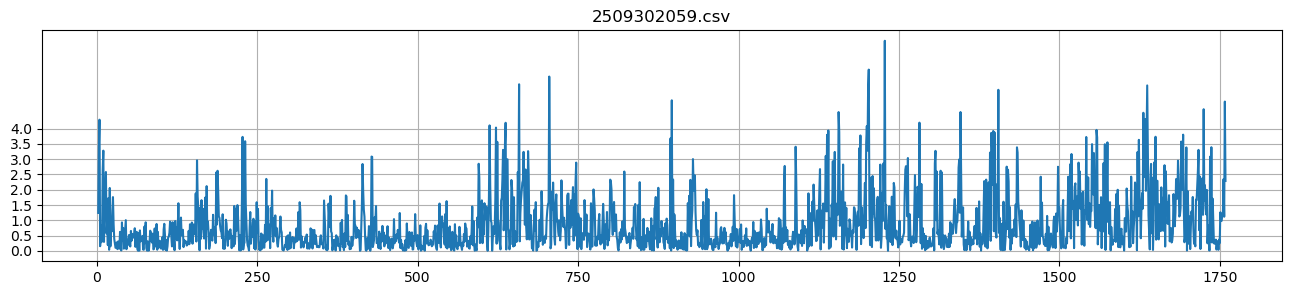

In [ ]:

# set x axis as travelled, y axis as dist

plt.figure(figsize=(16, 3))

# show y axis label every 0.5
plt.yticks(np.arange(0, 4.5, 0.5))

# show grid
plt.grid(True)
plt.title(filename)
plt.plot(pts_pl['Travelled'], pts_pl['dist'])
# save as png
plt.savefig(os.path.basename(filename) + '.png')
plt.show()

